In [2]:
import pandas as pd
import numpy as np
import helper_functions as hf
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
import importlib
importlib.reload(hf)
import math
import copy


In [10]:
#Rerunning glove to create quality vectors excluding test set

#metadata = ["AGE_CORRECTED", "BMI", "EXERCISE_FREQUENCY", "DOG", "ONE_LITER_OF_WATER_A_DAY_FREQUENCY", 
#         "COUNTRY", "SEX", "SEAFOOD_FREQUENCY", "PROBIOTIC_FREQUENCY", "OLIVE_OIL", "FRUIT_FREQUENCY", 
#         "SLEEP_DURATION", "RACE", "SUGAR_SWEETENED_DRINK_FREQUENCY", "MILK_CHEESE_FREQUENCY",
#         "DRINKING_WATER_SOURCE","RED_MEAT_FREQUENCY","MEAT_EGGS_FREQUENCY", "VEGETABLE_FREQUENCY"]

number_criteria = ["BMI", "AGE_CORRECTED"]
cat_criteria = ["EXERCISE_FREQUENCY", "SEX", "DOG", "ONE_LITER_OF_WATER_A_DAY_FREQUENCY", 
        "SEAFOOD_FREQUENCY", "PROBIOTIC_FREQUENCY", "OLIVE_OIL", "FRUIT_FREQUENCY", 
         "SLEEP_DURATION", "SUGAR_SWEETENED_DRINK_FREQUENCY", "MILK_CHEESE_FREQUENCY",
         "RED_MEAT_FREQUENCY","MEAT_EGGS_FREQUENCY", "VEGETABLE_FREQUENCY", "BODY_SITE"]

otu_file = "data/AG_new/allbodysites/otu_tables/otu_filtered_AG_02perc.csv"
mapping_file = "data/AG_new/AG_mapping.txt"
qual_vec_file = "embeddings/AG_new/glove_emb_AG_new_02perc_500_bodysite.txt"
test_samples_file = "data/AG_new/allbodysites/AG_test_samples.obj"
otu_train, otu_test, qual_vecs, map_train, map_test = hf.getDataAG(otu_file, mapping_file, qual_vec_file, 
                                                                   test_samples_file, number_criteria, cat_criteria)

Original data dimensions
Taxa: 21979  Samples: 15475


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\ctata\Documents\Lab\quality_vectors\helper_functions.py:36: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  qual_vecs_clean = qual_vecs.loc[[i in otu_clean.index.values for i in qual_vecs.index.values]] #keep taxa if present in otu


Filter for taxa present in embeddings
Taxa: 14336  Samples: 15475


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (0,81) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\ctata\Documents\Lab\quality_vectors\helper_functions.py:43: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  map_clean = mapping.loc[otu_clean.columns.values] #Keep samples if present in otu


Samples originally: 15475
Samples after categorical filter: 11645
Samples after numerical filter: 6447
Filter for desired metadata present
Samples: 6447  Taxa: 14336
(5847, 14336)
(5847, 17)
(600, 14336)
(600, 17)


In [2]:
f = open("data/AG_new/allbodysites/otu_train.obj", "rb")
otu_train = pickle.load(f)
f.close()

f = open("data/AG_new/allbodysites/otu_test.obj", "rb")
otu_test = pickle.load(f)
f.close()

f = open("data/AG_new/allbodysites/qual_vecs.obj", "rb")
qual_vecs = pickle.load(f)
f.close()

f = open("data/AG_new/allbodysites/map_train.obj", "rb")
map_train = pickle.load(f)
f.close()

f = open("data/AG_new/allbodysites/map_test.obj", "rb")
map_test = pickle.load(f)
f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'data/AG_new/otu_train.obj'

In [12]:

f = open("data/AG_new/allbodysites/otu_train.obj", "wb")
pickle.dump(otu_train, f)
f.close()

f = open("data/AG_new/allbodysites/otu_test.obj", "wb")
pickle.dump(otu_test, f)
f.close()

f = open("data/AG_new/allbodysites/qual_vecs.obj", "wb")
pickle.dump(qual_vecs, f)
f.close()

f = open("data/AG_new/allbodysites/map_train.obj", "wb")
pickle.dump(map_train, f)
f.close()

f = open("data/AG_new/allbodysites/map_test.obj", "wb")
pickle.dump(map_test, f)
f.close()

otu_train.to_csv("data/AG_new/allbodysites/otu_train.csv", header = True, index = True, index_label = "Sample")
otu_test.to_csv("data/AG_new/allbodysites/otu_test.csv", header = True, index = True, index_label = "Sample")

Write out OTU table and representative sequences for piphillan functional prediction. The ultimate goal is to compare embeddings distances to functional distances as a form of general validation.

In [174]:
qual_vecs.to_csv("data/AG_new/qual_vecs.csv", header = True, index = True, index_label = "OTU")

In [171]:
f = open("data/AG_new/otu_train.obj", "wb")
pickle.dump(otu_train_filt, f)
f.close()
print(otu_train_filt.shape)

(5820, 10498)


In [276]:
map_train.iloc[0:10, 0:10].to_csv("map_tmp.csv")

In [13]:


otu_norm = log_normalize(otu_train)
otu_norm_test = log_normalize(otu_test)

In [146]:
#otu_norm_rel = hf.normalize(otu_train_filt)
#otu_norm_rel_test = hf.normalize(otu_test_filt)

In [14]:
f = open("feature_selection/AG_new/ml_features_200_bodysite.obj", "rb")
ml_features = pickle.load(f)
f.close()

otu_ml = otu_norm[list(ml_features)]
otu_ml_test = otu_norm_test[list(ml_features)]

In [160]:
def randomfilter(otu, otu_test, numFeatures):
    np.random.seed(15)
    features = np.random.choice(otu.columns.values, numFeatures)
    otu_rand = otu[list(features)]
    otu_rand_test = otu_test[list(features)]
    
    return(otu_rand, otu_rand_test)

otu_rand, otu_rand_test = randomfilter(otu_norm, otu_norm_test, otu_ml.shape[1])


In [15]:
criteria = "BODY_SITE"
y_train = np.array(map_train[criteria])
y_test = np.array(map_test[criteria])

print(len(y_train))
print(len(y_test))

5847
600


In [16]:
def embed(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    df = pd.DataFrame(np.dot(log_normalize(otu), qual_vecs_use), index = otu.index.values)
    return(df)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def testModelClass(X_train, y_train, X_test, y_test, model = 'rf', title = ""):
    m = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140))
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    plot_confusion_matrix(y_test, preds, classes = np.unique(y_test), title = title)

Normalized confusion matrix
[[0.9962963  0.         0.         0.         0.0037037 ]
 [0.         0.42857143 0.14285714 0.28571429 0.14285714]
 [0.33333333 0.         0.66666667 0.         0.        ]
 [0.         0.         0.3        0.7        0.        ]
 [0.025      0.         0.         0.025      0.95      ]]


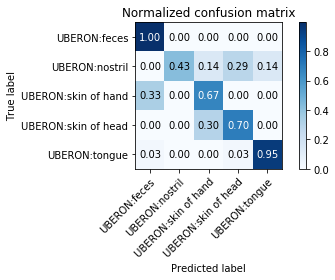

In [22]:
#Raw normalized data

X_train = preprocessing.scale(otu_norm)
X_test = preprocessing.scale(otu_norm_test)
y_train_bin = label_binarize(y_train, classes = np.unique(y_train))
y_test_bin = label_binarize(y_test, classes= np.unique(y_test))


m = OneVsRestClassifier(RandomForestClassifier(max_depth= 20, random_state=0, n_estimators=220))
m.fit(X_train, y_train)

preds = m.predict(X_test)
hf.plot_confusion_matrix(y_test, preds, classes = np.unique(y_test))

Normalized confusion matrix
[[0.99442379 0.         0.         0.         0.00557621]
 [0.14285714 0.42857143 0.         0.28571429 0.14285714]
 [0.         0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.4        0.6        0.        ]
 [0.025      0.         0.         0.025      0.95      ]]


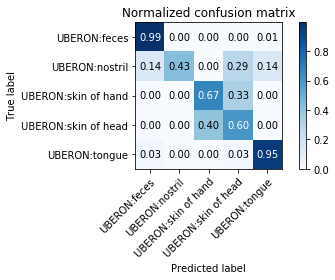

In [229]:
#Embed and weighted average of taxa abundance

X_train_embed = preprocessing.scale(embed(otu_norm, qual_vecs))
X_test_embed = preprocessing.scale(embed(otu_norm_test, qual_vecs))
y_train_bin = label_binarize(y_train, classes = np.unique(y_train))
y_test_bin = label_binarize(y_test, classes= np.unique(y_test))


m_embed = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140))
m_embed.fit(X_train_embed, y_train)
preds = m_embed.predict(X_test_embed)
plot_confusion_matrix(y_test, preds, classes = np.unique(y_test))

In [230]:
taxa_occurrence = otu_train.astype(bool)
taxa_present = taxa_occurrence.sum(axis = 0)

def embed_frequency(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    occurrence = otu.astype(bool)
    taxa_present_use = taxa_present[otu.columns.values]
    inverse_freq_mat = occurrence.div(taxa_present_use, axis = 1)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu.index.values)
    return(df)

c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype object were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype object were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


Normalized confusion matrix
[[0.99256506 0.00185874 0.         0.         0.00557621]
 [0.         0.28571429 0.28571429 0.42857143 0.        ]
 [0.         0.66666667 0.         0.33333333 0.        ]
 [0.         0.2        0.5        0.2        0.1       ]
 [0.05       0.         0.025      0.         0.925     ]]


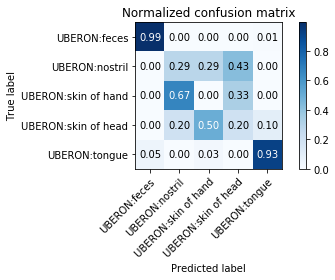

In [231]:
#Embed and weighted average by inverse taxa occurrence in samples

X_train_embed_freq = preprocessing.scale(embed_frequency(otu_ml, qual_vecs))
X_test_embed_freq = preprocessing.scale(embed_frequency(otu_ml_test, qual_vecs))

m_embed = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140))
m_embed.fit(X_train_embed_freq, y_train)

preds = m_embed.predict(X_test_embed_freq)
plot_confusion_matrix(y_test, preds, classes = np.unique(y_test))

In [232]:
otu_tmp = log_normalize(otu_train)
taxa_abundance = otu_tmp.sum(axis = 0)

def embed_count_frequency(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    occurrence = log_normalize(otu)
    taxa_abundance_use = taxa_abundance[otu.columns.values]
    inverse_freq_mat = occurrence.div(taxa_abundance_use, axis = 1)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu.index.values)
    return(df)

In [255]:
X_train_embed_count_freq = preprocessing.scale(embed_count_frequency(otu_norm, qual_vecs))
X_test_embed_count_freq = preprocessing.scale(embed_count_frequency(otu_norm_test, qual_vecs))

    

    
testModelClass(preprocessing.scale(embed_count_frequency(otu_norm, qual_vecs)), y_train,
             preprocessing.scale(embed_count_frequency(otu_norm_test, qual_vecs)), y_test,
              model = "rf", title = "Inverse abundance Weighting")

ValueError: Number of labels=5820 does not match number of samples=5295

# This concludes the body site prediction portion. Below, we will try to predict BMI using all gut microbiome information

In [45]:
importlib.reload(hf)

number_criteria = ["BMI", "AGE_CORRECTED"]
cat_criteria = ["EXERCISE_FREQUENCY", "SEX", "DOG", "ONE_LITER_OF_WATER_A_DAY_FREQUENCY", 
        "SEAFOOD_FREQUENCY", "PROBIOTIC_FREQUENCY", "OLIVE_OIL", "FRUIT_FREQUENCY", 
         "SLEEP_DURATION", "SUGAR_SWEETENED_DRINK_FREQUENCY", "MILK_CHEESE_FREQUENCY",
         "RED_MEAT_FREQUENCY","MEAT_EGGS_FREQUENCY", "VEGETABLE_FREQUENCY", "BODY_SITE"]

otu_file = "data/AG_new/feces/otu_filtered_AG_07perc_feces.csv"
mapping_file = "data/AG_new/AG_mapping.txt"
qual_vec_file = "data/AG_new/feces/glove_emb_AG_new07perc_feces_500.txt"
test_samples_file = "data/AG_new/feces/AG_test_samples_feces.obj"
otu_train, otu_test, qual_vecs, map_train, map_test = hf.getDataAG(otu_file, mapping_file, qual_vec_file, test_samples_file,
                                                                   number_criteria, cat_criteria)

Original data dimensions
Taxa: 9162  Samples: 15475


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\ctata\Documents\Lab\quality_vectors\helper_functions.py:47: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


Filter for taxa present in embeddings
Taxa: 6144  Samples: 15475


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (0,81) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\ctata\Documents\Lab\quality_vectors\helper_functions.py:54: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  keep = [(i and j) for (i,j) in zip(keep, keep_tmp)]


Samples originally: 15475
Samples after categorical filter: 14082
Samples after numerical filter: 8731
Filter for desired metadata present
Samples: 8731  Taxa: 6144
(7580, 6144)
(7580, 5)
(1151, 6144)
(1151, 5)


In [26]:
#Sample should have BMI under 100
otu_train_filt = otu_train.loc[[float(i) < 100 for i in map_train["BMI"]], :]
otu_test_filt = otu_test.loc[[float(i) < 100 for i in map_test["BMI"]], :]

#Discard samples that have no taxa
otu_train_filt = otu_train_filt.loc[otu_train_filt.sum(axis = 1) > 0, :]
otu_test_filt = otu_test_filt.loc[otu_test_filt.sum(axis = 1) > 0, :]

#Discard taxa that have no samples
taxa_keep_train = np.array(otu_train_filt.sum(axis = 0) > 0)
taxa_keep_test = np.array(otu_test_filt.sum(axis = 0) > 0)
taxa_keep = [taxa_keep_train[i] & taxa_keep_test[i] for i in range(otu_train_filt.shape[1])]
otu_train_filt = otu_train_filt.loc[:, taxa_keep]
otu_test_filt = otu_test_filt.loc[:, taxa_keep]

map_train = map_train.loc[otu_train_filt.index.values]
map_test = map_test.loc[otu_test_filt.index.values]

map_train = map_train[number_criteria + cat_criteria]
map_test = map_test[number_criteria + cat_criteria]

print(otu_train_filt.shape)
print(map_train.shape)
print(otu_test_filt.shape)
print(map_test.shape)

otu_train = copy.deepcopy(otu_train_filt)
otu_test = copy.deepcopy(otu_test_filt)


(5525, 6079)
(5525, 17)
(893, 6079)
(893, 17)


In [28]:
#Save objects to avoid having to reload

f = open("data/AG_new/feces/otu_train_feces.obj", "wb")
pickle.dump(otu_train, f)
f.close()

f = open("data/AG_new/feces/otu_test_feces.obj", "wb")
pickle.dump(otu_test, f)
f.close()

f = open("data/AG_new/feces/qual_vecs_feces.obj", "wb" )
pickle.dump(qual_vecs, f)
f.close()

f = open("data/AG_new/feces/map_train_feces.obj", "wb")
pickle.dump(map_train, f)
f.close()

f = open("data/AG_new/feces/map_test_feces.obj", "wb")
pickle.dump(map_test, f)
f.close()

In [29]:
#Load saved objects instead of reading from file
f = open("data/AG_new/feces/otu_train_feces.obj", "rb")
otu_train = pickle.load(f)
f.close()

f = open("data/AG_new/feces/otu_test_feces.obj", "rb")
otu_test = pickle.load(f)
f.close()

f = open("data/AG_new/feces/qual_vecs_feces.obj", "rb")
qual_vecs = pickle.load(f)
f.close()

f = open("data/AG_new/feces/map_train_feces.obj", "rb")
map_train = pickle.load(f)
f.close()

f = open("data/AG_new/feces/map_test_feces.obj", "rb")
map_test = pickle.load(f)
f.close()

In [30]:
print(otu_train.shape)
print(map_train.shape)
print(otu_test.shape)
print(map_test.shape)
max([float(i) for i in map_train["BMI"]])

(5525, 6079)
(5525, 17)
(893, 6079)
(893, 17)


76.89

In [31]:
def plotLineOfBestFit(xi, y, title = ""):
    #plt.figure(figsize=(15,5))
    print(np.max(y))

    #y = y.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
    line = slope*xi+intercept
    plt.plot(xi,y,'o', xi, line)
    
    #perfect line
    #plt.plot(
    
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title(title)
    plt.ylim((np.min(xi),np.max(xi)))
    print("Slope: " + str(slope))
    print("R value: " + str(r_value))



In [37]:
otu_norm = hf.asinh(otu_train)
otu_norm_test = hf.asinh(otu_test)

In [38]:
f = open("feature_selection/AG_new/ml_features_500_bmi.obj", "rb")
ml_features = pickle.load(f)
f.close()

otu_ml = otu_train[list(ml_features)]
otu_ml_test = otu_test[list(ml_features)]

In [36]:
print(otu_ml.shape)
print(otu_ml_test.shape)


(5525, 213)
(893, 213)


In [39]:
#Convert categorical to numerical
map_train_correct = copy.deepcopy(map_train)
map_test_correct = copy.deepcopy(map_test)



def makeNumeric(var, dictionary, map_train, map_test, map_train_correct, map_test_correct):
    map_train_correct[var] = [dictionary[i] for i in map_train[var]]
    map_test_correct[var] = [dictionary[i] for i in map_test[var]]
    return(map_train_correct, map_test_correct)

map_train_correct["AGE_CORRECTED"] = [float(i) for i in map_train["AGE_CORRECTED"]]
map_test_correct["AGE_CORRECTED"] = [float(i) for i in map_test["AGE_CORRECTED"]]


freq_dict = {"Never": 0, "Rarely (a few times/month)":1, "Occasionally (1-2 times/week)": 2,
             "Regularly (3-5 times/week)":3, "Daily":4, "Rarely (less than once/week)" : 1}

freq_vars = ["EXERCISE_FREQUENCY", "ONE_LITER_OF_WATER_A_DAY_FREQUENCY", "SEAFOOD_FREQUENCY", "PROBIOTIC_FREQUENCY", 
             "OLIVE_OIL", "FRUIT_FREQUENCY", "SUGAR_SWEETENED_DRINK_FREQUENCY", "MILK_CHEESE_FREQUENCY", "RED_MEAT_FREQUENCY",
            "MEAT_EGGS_FREQUENCY", "VEGETABLE_FREQUENCY"]
for var in freq_vars:
    print(var)
    map_train_correct, map_test_correct = makeNumeric(var, freq_dict, map_train, map_test, map_train_correct, map_test_correct)

sex_dict = {"male": 0, "female":1}
map_train_correct, map_test_correct = makeNumeric("SEX", sex_dict, map_train, map_test, map_train_correct, map_test_correct)

sleep_dict = {"Less than 5 hours":1, "5-6 hours":2, "6-7 hours":3, "7-8 hours":4, "8 or more hours":5 }
map_train_correct, map_test_correct = makeNumeric("SLEEP_DURATION", sleep_dict, map_train, map_test, map_train_correct, map_test_correct)

dog_dict = {"false": 0, "true": 1, "No":0, "Yes":1}
map_train_correct, map_test_correct = makeNumeric("DOG", dog_dict,  map_train, map_test, map_train_correct, map_test_correct)




EXERCISE_FREQUENCY
ONE_LITER_OF_WATER_A_DAY_FREQUENCY
SEAFOOD_FREQUENCY
PROBIOTIC_FREQUENCY
OLIVE_OIL
FRUIT_FREQUENCY
SUGAR_SWEETENED_DRINK_FREQUENCY
MILK_CHEESE_FREQUENCY
RED_MEAT_FREQUENCY
MEAT_EGGS_FREQUENCY
VEGETABLE_FREQUENCY


In [41]:
#Both of these functions need to take in non-normalized data

taxa_occurrence = otu_train.astype(bool)
taxa_present = taxa_occurrence.sum(axis = 0) #total number of occurrences (0,1) of each taxa

def embed_frequency(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    occurrence = otu.astype(bool)
    taxa_present_use = taxa_present[otu.columns.values]
    inverse_freq_mat = occurrence.div(taxa_present_use, axis = 1)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu.index.values)
    return(df)

otu_tmp = asinh(otu_ml)
taxa_abundance = otu_tmp.sum(axis = 0) #total count of each taxa

def embed_count_frequency(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    occurrence = log_normalize(otu)
    taxa_abundance_use = taxa_abundance[otu.columns.values]
    inverse_freq_mat = occurrence.div(taxa_abundance_use, axis = 1)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu.index.values)
    return(df)

def embed(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    df = pd.DataFrame(np.dot(asinh(otu), qual_vecs_use), index = otu.index.values)
    return(df)

In [51]:
print(otu_ml.shape)
print(map_train.shape)

(5525, 213)
(5525, 17)


In [42]:
#Create input for ML alg including otu abundances and metadata
y_train = [float(i) for i in map_train_correct["BMI"]]
y_test = [float(i) for i in map_test_correct["BMI"]]
map_train_correct = map_train_correct.drop(["BMI", "BODY_SITE"], axis = 1)
map_test_correct = map_test_correct.drop(["BMI", "BODY_SITE"], axis = 1)

In [43]:

np.sum([i == j for (i,j) in zip(otu_ml.index.values, map_train.index.values)])
input_ml_train = pd.concat([asinh(otu_ml), map_train_correct], axis = 1)
input_ml_test = pd.concat([asinh(otu_ml_test), map_test_correct], axis = 1)

input_ml_emb_train = pd.concat([embed(otu_ml, qual_vecs), map_train_correct], axis = 1)
input_ml_emb_test = pd.concat([embed(otu_ml_test, qual_vecs), map_test_correct], axis = 1)

input_ml_embfreq_train = pd.concat([embed_frequency(otu_ml, qual_vecs), map_train_correct], axis = 1)
input_ml_embfreq_test = pd.concat([embed_frequency(otu_ml_test, qual_vecs), map_test_correct], axis = 1)

input_ml_embcountfreq_train = pd.concat([embed_count_frequency(otu_ml, qual_vecs), map_train_correct], axis = 1)
input_ml_embcountfreq_test = pd.concat([embed_count_frequency(otu_ml_test, qual_vecs), map_test_correct], axis = 1)


In [56]:
print(otu_ml.shape)
print(otu_ml_test.shape)
print(len(y_train))
print(len(y_test))

(5525, 213)
(893, 213)
5525
893


71.61
Slope: 1.4802650699408597
R value: 0.35834793920986224
Linear Error3.505126614720091   MSE: 27.478350221274837


(SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 3.505126614720091,
 27.478350221274837)

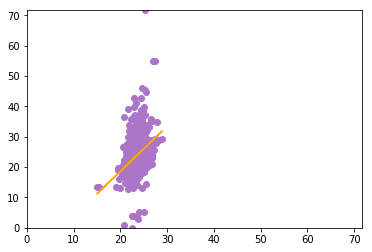

In [57]:
hf.testModel(preprocessing.scale(hf.asinh(otu_ml)), y_train,
            preprocessing.scale(hf.asinh(otu_ml_test)), y_test,
            model = "svm", title = "No Embedding")

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


71.61
Slope: 1.0867024403351102
R value: 0.4580915523013246
Linear Error3.2360743191980887   MSE: 24.61704218132478


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':


71.61
Slope: 0.9763894804319657
R value: 0.42825612986990896
Linear Error3.3308964814239674   MSE: 25.493070910593882


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by the scale function.
  app.launch_new_instance()
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by the scale function.


71.61
Slope: 0.8586663403236617
R value: 0.38946946396304194
Linear Error3.4033682115018955   MSE: 26.62489363369787


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.


71.61
Slope: 0.7741387309106863
R value: 0.380819869424074
Linear Error3.3876520575520024   MSE: 27.121158162623484


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
 3.3876520575520024,
 27.121158162623484)

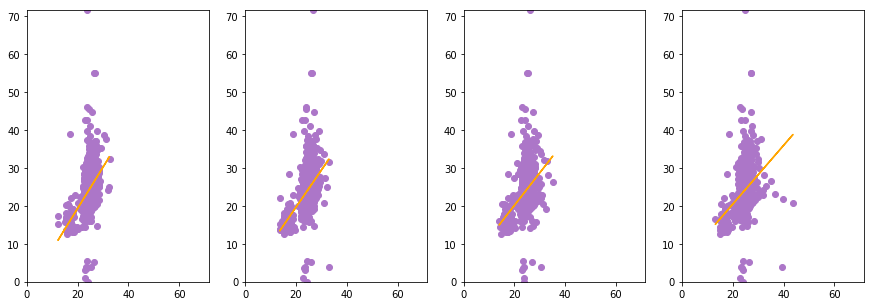

In [44]:
#This is useless until you update the embeddings for just feces
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)

hf.testModel(preprocessing.scale(input_ml_train), y_train,
             preprocessing.scale(input_ml_test), y_test,
              model = "rf", title = "No Embedding")


plt.subplot( 1, 4, 2)
hf.testModel(preprocessing.scale(input_ml_emb_train), y_train,
             preprocessing.scale(input_ml_emb_test), y_test,
              model = "rf", title = "Average Abundance Weighting")

plt.subplot( 1, 4, 3)
hf.testModel(preprocessing.scale(input_ml_embfreq_train), y_train,
             preprocessing.scale(input_ml_embfreq_test), y_test,
              model = "rf", title = "Inverse Frequency Weighting")

plt.subplot( 1, 4, 4)
hf.testModel(preprocessing.scale(input_ml_embcountfreq_train), y_train,
             preprocessing.scale(input_ml_embcountfreq_test), y_test,
              model = "rf", title = "Inverse Frequency Weighting")



C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


76.89
Slope: 1.107301116846391
R value: 0.46591065562261647
Linear Error3.1835853578376243   MSE: 27.08957272212684


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


76.89
Slope: 1.0652169818090902
R value: 0.42640199138538054
Linear Error3.288568023678152   MSE: 28.284928141608322


(3.288568023678152, 28.284928141608322)

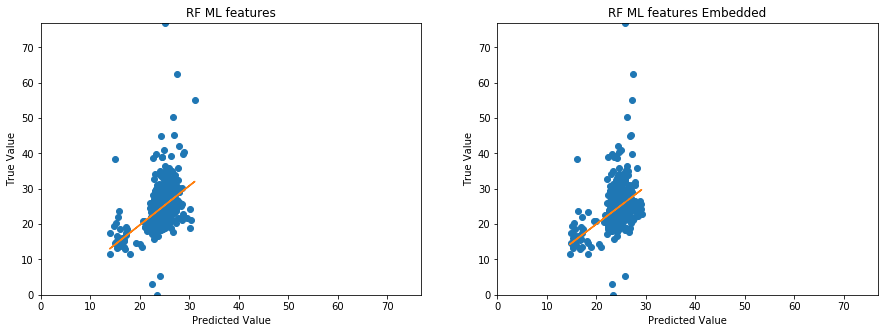

In [164]:

testModelClass(preprocessing.scale(input_ml_embfreq_train), y_train,
             preprocessing.scale(input_ml_embfreq_test), y_test,
              model = "rf", title = "Inverse abundance Weighting")


plt.subplot( 1, 2, 2)
testModelClass(preprocessing.scale(input_ml_embfreq_train), y_train,
             preprocessing.scale(input_ml_embfreq_test), y_test,
              model = "rf", title = "Inverse abundance Weighting")

76.89
Slope: 1.0331972966734908
R value: 0.06574774135152364
Linear Error3.864635123139554   MSE: 34.981868659618115
76.89
Slope: 0.923389911520611
R value: 0.041642494260796005
Linear Error3.8585681773070166   MSE: 35.097798837249655


(3.8585681773070166, 35.097798837249655)

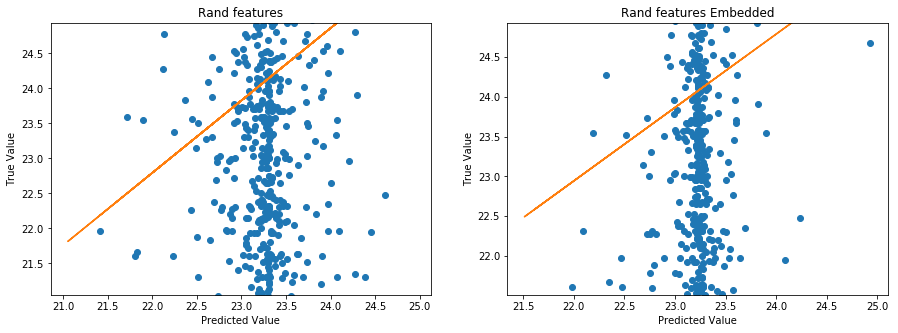

In [33]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_rand), y_train, 
             preprocessing.scale(otu_rand_test), y_test, model = "svm", title = "Rand features")

plt.subplot(1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_rand, qual_vecs)), y_train, 
             preprocessing.scale(hf.embed(otu_rand_test, qual_vecs)), y_test, model = "svm", title = "Rand features Embedded")

In [5]:
otu_use = pd.read_csv("data/AG_new/feces/otu_filtered_AG_07perc_feces.csv", sep = '\t', index_col = 0)
print(otu_use.shape)

(9162, 15475)


In [10]:

include = otu_use.index.values

records = []
from Bio import SeqIO
i = 0
for record in SeqIO.parse("data/greengenes/gg_13_8_otus/rep_set/97_otus.fasta", "fasta"):
    if int(record.id) in include:
        records.append(SeqIO.SeqRecord(record.seq, "seq" + str(record.id), description = ""))

SeqIO.write(records, "data/AG_new/feces/repseqs.fasta", "fasta")

9162

Now we'll try to predict IBD status, which should be somewhere in between body site classification and BMI in terms of difficulty

In [5]:
importlib.reload(hf)

number_criteria = []

cat_criteria = ["BODY_SITE", "IBD", "GLUTEN", "SEX"]
otu_file = "data/AG_new/feces/otu_filtered_AG_07perc_feces.csv"
mapping_file = "data/AG_new/AG_mapping.txt"
qual_vec_file = "data/AG_new/feces/glove_emb_AG_new07perc_feces_500.txt"
test_samples_file = "data/AG_new/feces/AG_test_samples_feces.obj"
otu_train, otu_test, qual_vecs, map_train, map_test = hf.getDataAG(otu_file, mapping_file, qual_vec_file, test_samples_file,
                                                                   number_criteria, cat_criteria)

Original data dimensions
Taxa: 9162  Samples: 15475


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\ctata\Documents\Lab\quality_vectors\helper_functions.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  qual_vecs_clean = qual_vecs.loc[[i in otu_clean.index.values for i in qual_vecs.index.values]] #keep taxa if present in otu


Filter for taxa present in embeddings
Taxa: 6144  Samples: 15475


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (0,81) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\ctata\Documents\Lab\quality_vectors\helper_functions.py:55: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  map_clean = mapping.loc[otu_clean.columns.values] #Keep samples if present in otu


Samples originally: 15475
Samples after categorical filter: 8951
Samples after numerical filter: 8951
Filter for desired metadata present
Samples: 8951  Taxa: 6144
(7784, 6144)
(7784, 4)
(1167, 6144)
(1167, 4)


In [82]:
from collections import Counter
freq = Counter(map_train["IBD"])
freq

freq = Counter(map_train["GLUTEN"])
freq

Counter({'I do not eat gluten because it makes me feel bad': 1007,
         'I was diagnosed with celiac disease': 100,
         'I was diagnosed with gluten allergy (anti-gluten IgG), but not celiac disease': 206,
         'No': 6647})

In [6]:

#Discard samples that have no taxa
otu_train_filt = otu_train.loc[otu_train.sum(axis = 1) > 0, :]
otu_test_filt = otu_test.loc[otu_test.sum(axis = 1) > 0, :]

#Discard taxa that have no samples
taxa_keep_train = np.array(otu_train_filt.sum(axis = 0) > 0)
taxa_keep_test = np.array(otu_test_filt.sum(axis = 0) > 0)
taxa_keep = [taxa_keep_train[i] & taxa_keep_test[i] for i in range(otu_train_filt.shape[1])]
otu_train_filt = otu_train_filt.loc[:, taxa_keep]
otu_test_filt = otu_test_filt.loc[:, taxa_keep]

map_train = map_train.loc[otu_train_filt.index.values]
map_test = map_test.loc[otu_test_filt.index.values]

map_train = map_train[number_criteria + cat_criteria]
map_test = map_test[number_criteria + cat_criteria]

print(otu_train_filt.shape)
print(map_train.shape)
print(otu_test_filt.shape)
print(map_test.shape)

otu_train = copy.deepcopy(otu_train_filt)
otu_test = copy.deepcopy(otu_test_filt)


(7784, 6113)
(7784, 4)
(1167, 6113)
(1167, 4)


In [100]:
#Load saved objects instead of reading from file
f = open("data/AG_new/feces/otu_train_ibd.obj", "rb")
otu_train = pickle.load(f)
f.close()

f = open("data/AG_new/feces/otu_test_ibd.obj", "rb")
otu_test = pickle.load(f)
f.close()

f = open("data/AG_new/feces/qual_vecs_ibd.obj", "rb")
qual_vecs = pickle.load(f)
f.close()

f = open("data/AG_new/feces/map_train_ibd.obj", "rb")
map_train = pickle.load(f)
f.close()

f = open("data/AG_new/feces/map_test_ibd.obj", "rb")
map_test = pickle.load(f)
f.close()

In [7]:
#Save objects to avoid having to reload

f = open("data/AG_new/feces/otu_train_ibd.obj", "wb")
pickle.dump(otu_train, f)
f.close()

f = open("data/AG_new/feces/otu_test_ibd.obj", "wb")
pickle.dump(otu_test, f)
f.close()

f = open("data/AG_new/feces/qual_vecs_ibd.obj", "wb" )
pickle.dump(qual_vecs, f)
f.close()

f = open("data/AG_new/feces/map_train_ibd.obj", "wb")
pickle.dump(map_train, f)
f.close()

f = open("data/AG_new/feces/map_test_ibd.obj", "wb")
pickle.dump(map_test, f)
f.close()

In [101]:
#Convert categorical to numerical
map_train_correct = copy.deepcopy(map_train)
map_test_correct = copy.deepcopy(map_test)



def makeNumeric(var, dictionary, map_train, map_test, map_train_correct, map_test_correct):
    map_train_correct[var] = [dictionary[i] for i in map_train[var]]
    map_test_correct[var] = [dictionary[i] for i in map_test[var]]
    return(map_train_correct, map_test_correct)

sex_dict = {"male": 0, "female":1}
map_train_correct, map_test_correct = makeNumeric("SEX", sex_dict, map_train, map_test, map_train_correct, map_test_correct)

ibd_dict = {'I do not have this condition':0, 'Self-diagnosed':1, 
            'Diagnosed by a medical professional (doctor, physician assistant)':1,
            'Diagnosed by an alternative medicine practitioner':1}
map_train_correct, map_test_correct = makeNumeric("IBD", ibd_dict, map_train, map_test, map_train_correct, map_test_correct)

gluten_dict = {"No":0, 'I do not eat gluten because it makes me feel bad':1, 'I was diagnosed with celiac disease':1,
               'I was diagnosed with gluten allergy (anti-gluten IgG), but not celiac disease':1}
map_train_correct, map_test_correct = makeNumeric("GLUTEN", gluten_dict, map_train, map_test, map_train_correct, map_test_correct)



In [102]:
#Both of these functions need to take in non-normalized data

#Embed weighted by the number of times an organisms appears
taxa_occurrence = otu_train > 1
taxa_present = taxa_occurrence.sum(axis = 0) #total number of occurrences (0,1) of each taxa
taxa_present = taxa_present + 1

def embed_occurrence(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    occurrence = np.matrix(otu > 1)
    taxa_present_use = np.array(taxa_present[otu.columns.values])
    inverse_freq_mat = pd.DataFrame(occurrence / taxa_present_use)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu.index.values)
    return(df)

#Embed weighted by the inverse of the overall normalized abundance of that organism in ALL samples
otu_tmp = hf.asinh(otu_train)
taxa_abundance = otu_tmp.sum(axis = 0) #total abundance of each taxa summed over samples

def embed_abundance(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    abundance = np.matrix(hf.asinh(otu))
    overall_taxa_abundance = np.array(taxa_abundance[otu.columns.values])
    inverse_freq_mat = pd.DataFrame(abundance / overall_taxa_abundance)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu.index.values)
    return(df)

def embed_average(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    df = pd.DataFrame(np.dot(hf.asinh(otu), qual_vecs_use), index = otu.index.values)
    return(df)

### Predict IBD

In [103]:
#Create input for ML alg including otu abundances and metadata
criteria = "IBD"
y_train = [float(i) for i in map_train_correct[criteria]]
y_test = [float(i) for i in map_test_correct[criteria]]
map_train_correct = map_train_correct.drop([criteria, "BODY_SITE"], axis = 1)
map_test_correct = map_test_correct.drop([criteria, "BODY_SITE"], axis = 1)

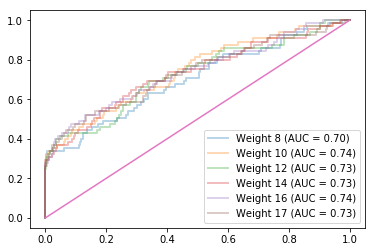

In [81]:
#Embed and weighted average by inverse taxa occurrence in samples
importlib.reload(hf)
X_train = preprocessing.scale(otu_train)
X_test = preprocessing.scale(otu_test)

weight_list = [ 8, 10, 12, 14, 16, 17]
for weight in weight_list:
    weights = {0:1, 1:weight}
    m = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140, class_weight = weights))
    m.fit(X_train, y_train)
    probs = m.predict_proba(X_test)

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3,
             label='Weight %d (AUC = %0.2f)' % (weight, roc_auc))
plt.legend(loc="lower right")
x = np.linspace(0, 1, 10)
plt.plot(x, x)



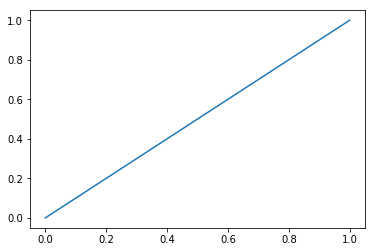

In [75]:
x = np.linspace(0, 1, 10)
plt.plot(x, x)

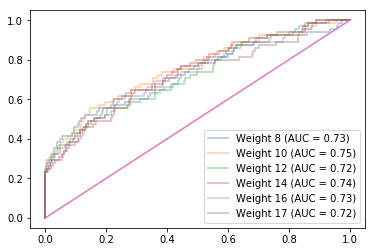

In [80]:
X_train = preprocessing.scale(embed_average(otu_train, qual_vecs))
X_test = preprocessing.scale(embed_average(otu_test, qual_vecs))

weight_list = [ 8, 10, 12, 14, 16, 17]
for weight in weight_list:
    weights = {0:1, 1:weight}
    m = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140, class_weight = weights))
    m.fit(X_train, y_train)
    probs = m.predict_proba(X_test)

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3,
             label='Weight %d (AUC = %0.2f)' % (weight, roc_auc))
plt.legend(loc="lower right")
x = np.linspace(0, 1, 10)
plt.plot(x, x)

In [82]:
otu_train.shape

(7784, 6113)

99


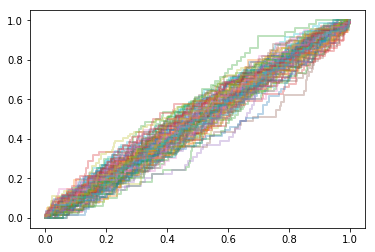

In [104]:
#Random labels for IBD prediction
X_train = preprocessing.scale(otu_train)
X_test = preprocessing.scale(otu_test)


print(i)
weight = 10
weights = {0:1, 1:weight}
m = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140, class_weight = weights))
m.fit(X_train, y_train)
probs = m.predict_proba(X_test)

iterations = 100
aucs = []
for i in range(iterations):
    y_train_new, y_test_new = getRandomLabels(y_train, y_test)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test_new, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3)

### GLUTEN PREDICTION

In [83]:
#Create input for ML alg including otu abundances and metadata
criteria = "GLUTEN"
y_train = [float(i) for i in map_train_correct[criteria]]
y_test = [float(i) for i in map_test_correct[criteria]]
map_train_correct = map_train_correct.drop([criteria], axis = 1)
map_test_correct = map_test_correct.drop([criteria], axis = 1)

In [49]:
ratio = np.sum([i == 0 for i in y_train]) / np.sum([i ==1 for i in y_train])


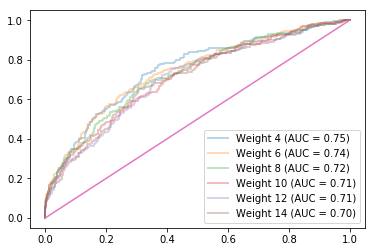

In [84]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
X_train = preprocessing.scale(otu_train)
X_test = preprocessing.scale(otu_test)

weight_list = [ 4, 6, 8, 10, 12, 14]
for weight in weight_list:
    weights = {0:1, 1:weight}
    m = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140, class_weight = weights))
    m.fit(X_train, y_train)
    probs = m.predict_proba(X_test)

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3,
             label='Weight %d (AUC = %0.2f)' % (weight, roc_auc))
plt.legend(loc="lower right")
x = np.linspace(0, 1, 10)
plt.plot(x, x)

Normalized confusion matrix
[[0.88008342 0.11991658]
 [0.63461538 0.36538462]]


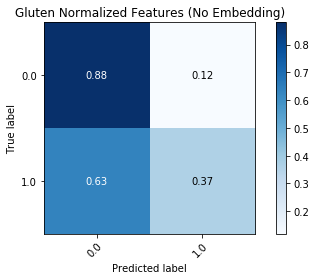

In [51]:
#Embed and weighted average by inverse taxa occurrence in samples
importlib.reload(hf)
X_train = preprocessing.scale(otu_train)
X_test = preprocessing.scale(otu_test)

def testModelClass(X_train, y_train, X_test, y_test, model = 'rf', weights, title){ 
   
}
    
    
testModelClass(X_train, y_train, X_test, y_test,
              model = "rf", weights={0:1, 1:10}, title = "Gluten Normalized Features (No Embedding)")



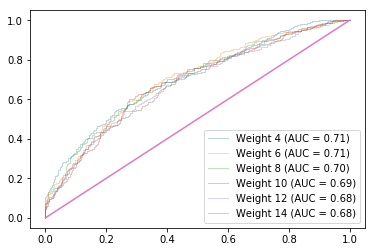

In [85]:
X_train = preprocessing.scale(embed_average(otu_train, qual_vecs))
X_test = preprocessing.scale(embed_average(otu_test, qual_vecs))

weight_list = [ 4, 6, 8, 10, 12, 14]
aucs = []
for weight in weight_list:
    weights = {0:1, 1:weight}
    m = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140, class_weight = weights))
    m.fit(X_train, y_train)
    probs = m.predict_proba(X_test)

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='Weight %d (AUC = %0.2f)' % (weight, roc_auc))
plt.legend(loc="lower right")
x = np.linspace(0, 1, 10)
plt.plot(x, x)

In [90]:
#randomly assign labels, and try to predict ibd. Do this 100 times and record the auc's of each 
from numpy.random import choice
def getRandomLabels(y_train, y_test):
    num_0 = np.sum([i == 0 for i in y_train])
    num_1 = np.sum([i == 1 for i in y_train])
    y_train_new = choice([0,1], len(y_train), p=[num_0 / len(y_train), num_1 / len(y_train)])

    num_0 = np.sum([i == 0 for i in y_test])
    num_1 = np.sum([i == 1 for i in y_test])
    y_test_new = choice([0,1], len(y_test), p=[num_0 / len(y_test), num_1 / len(y_test)])
    return(y_train_new, y_test_new)

y_train_new, y_test_new = getRandomLabels(y_train, y_test)

99


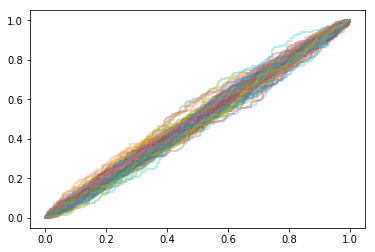

In [98]:
#Random labels
X_train = preprocessing.scale(otu_train)
X_test = preprocessing.scale(otu_test)


print(i)
weight = 10
weights = {0:1, 1:weight}
m = OneVsRestClassifier(RandomForestClassifier(max_depth= 12, random_state=0, n_estimators=140, class_weight = weights))
m.fit(X_train, y_train)
probs = m.predict_proba(X_test)

iterations = 100
aucs = []
for i in range(iterations):
    y_train_new, y_test_new = getRandomLabels(y_train, y_test)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test_new, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3)


In [99]:
np.mean(aucs)

0.4992936845540173

#Get representative sequences for relevant taxa

for i in range(round(otu_train.shape[0])):
    start = 500 * i
    end = start + 500
    print(str(start) + "-" + str(end))
    if end > otu_train.shape[0]:
        end = otu_train.shape[0] - 1
        
    sample_range = range(start, end)
    otu_tmp = otu_train.iloc[sample_range, :]
    index = ["sample" + str(i) for i in range(otu_tmp.shape[0])]
    include = set(otu_tmp.columns.values)
    otu_tmp = pd.DataFrame(otu_tmp.values, index = index, columns =['seq' + str(i) for i in otu_tmp.columns.values])

    otu_tmp = otu_tmp.T
    f = open("data/AG_new/otu_" + str(end) + ".csv", "w")
    otu_tmp.to_csv(f, columns = otu_tmp.columns.values, index_label = "OTU")
    f.close()
    
    
    records = []
    from Bio import SeqIO
    i = 0
    for record in SeqIO.parse("data/greengenes/gg_13_8_otus/rep_set/97_otus.fasta", "fasta"):
        if int(record.id) in include:
            records.append(SeqIO.SeqRecord(record.seq, "seq" + str(record.id), description = ""))

    SeqIO.write(records, "data/AG_new/repseqs_" + str(end) + ".fasta", "fasta")